In [2]:
%matplotlib notebook

import numpy as np

# Synthetic Data (4 Layers, 10 Time Steps)

In [3]:
from multidynet.datasets import simple_dynamic_multilayer_network
from multidynet.plots import plot_network

lmbda = np.array([[1., 1.],
                  [0.5, -0.5],
                  [-2.0, 2.0],
                  [-1., -1.]])

Y, X, lmbda, intercept = simple_dynamic_multilayer_network(
    n_nodes=100, n_time_steps=10,
    tau_sq=4.0, sigma_sq=0.1,
    lmbda=lmbda, intercept=-1.0,
    assortative_reference=False,
    random_state=423)

## Layer 1

<IPython.core.display.Javascript object>


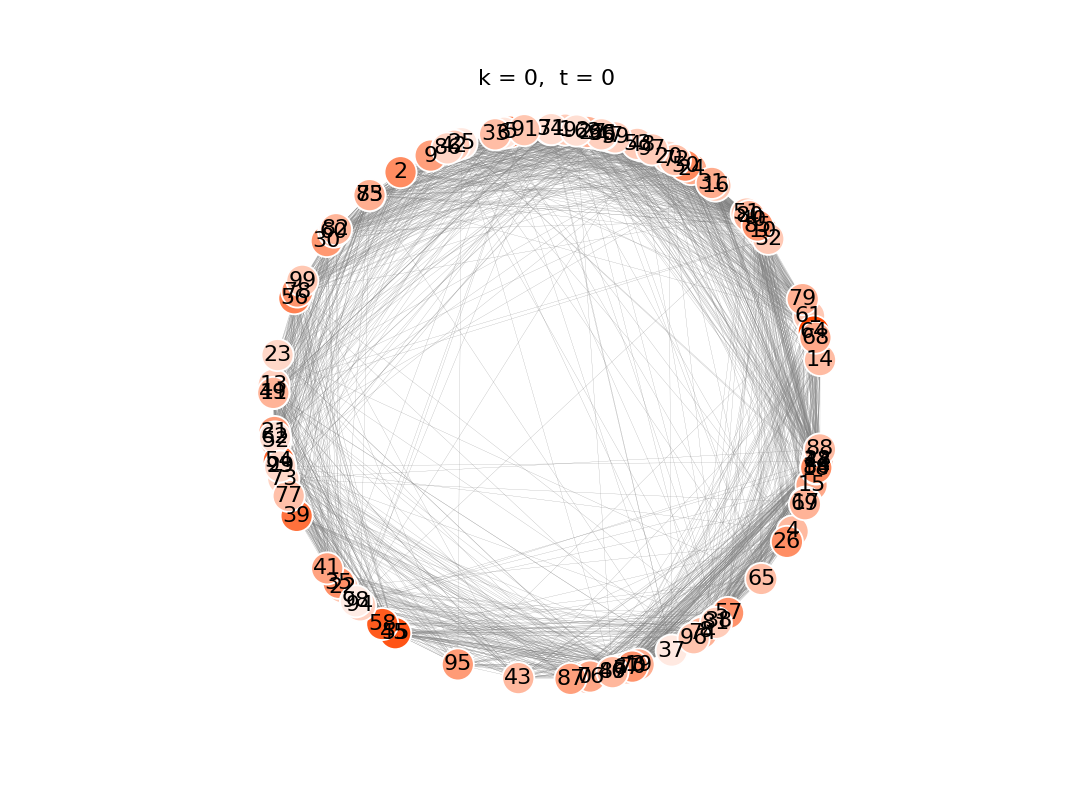

Text(0.5, 1.0, 'k = 0,  t = 0')

In [75]:
t = 0
k = 0

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 2

<IPython.core.display.Javascript object>


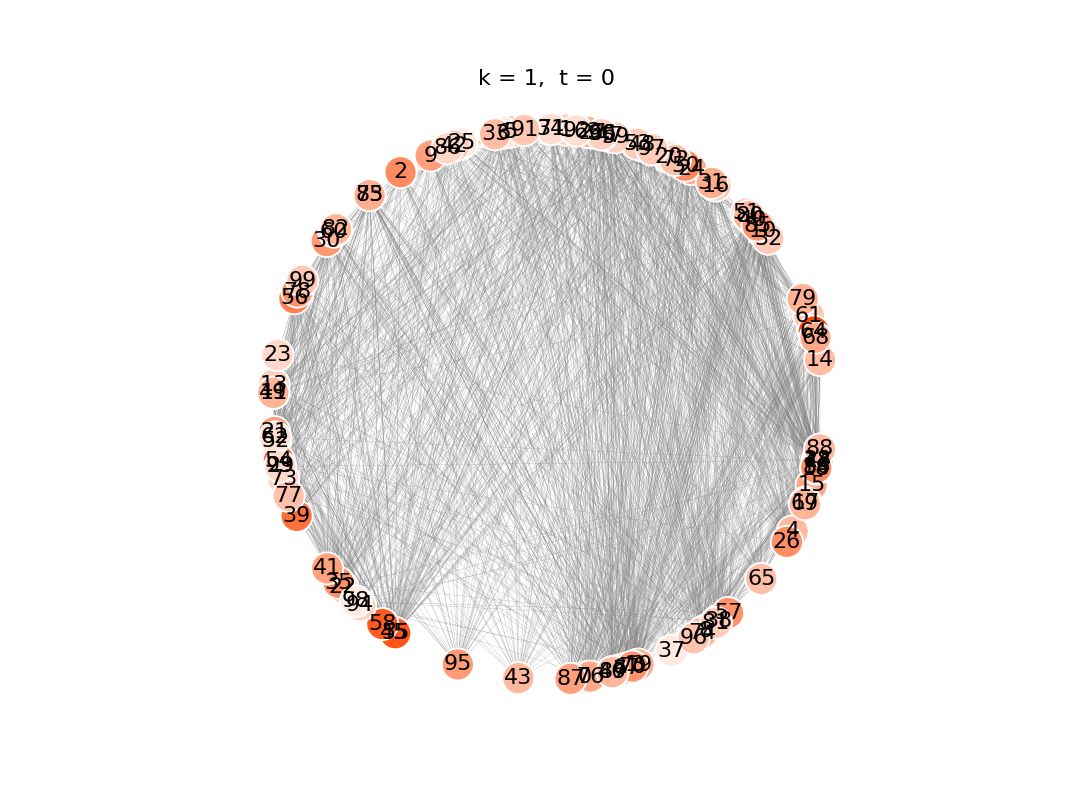

Text(0.5, 1.0, 'k = 1,  t = 0')

In [5]:
t = 0
k = 1

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 3

<IPython.core.display.Javascript object>


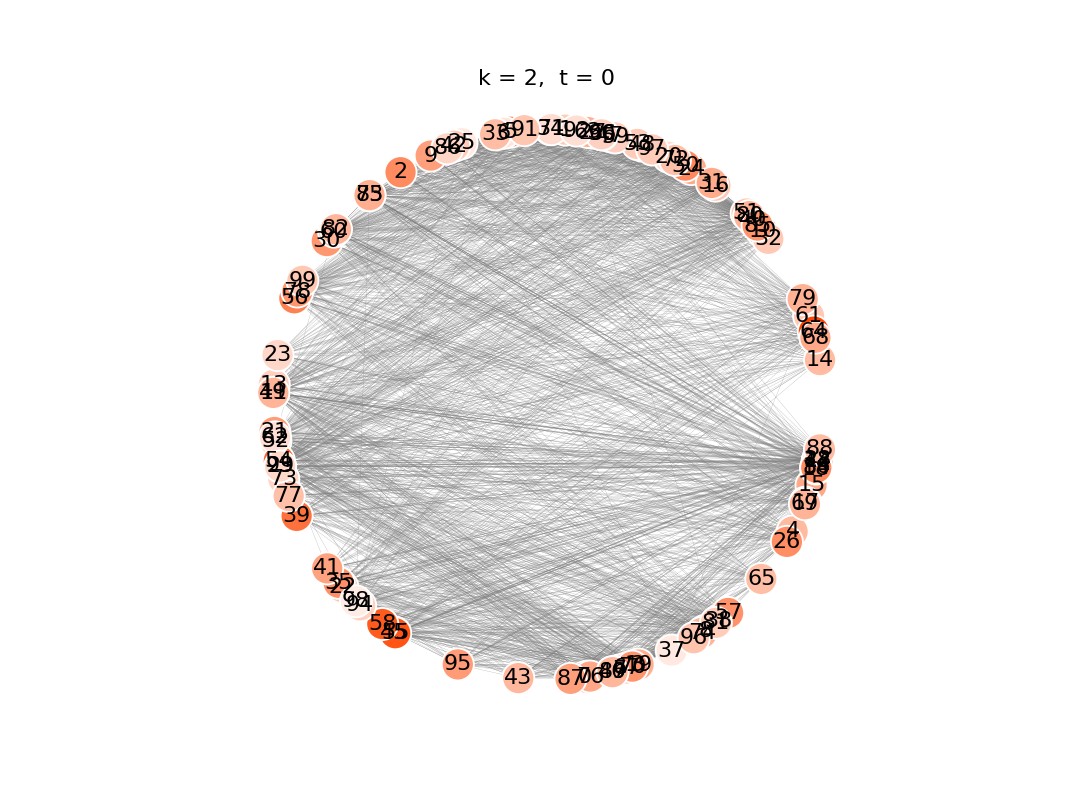

Text(0.5, 1.0, 'k = 2,  t = 0')

In [77]:
t = 0
k = 2

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

## Layer 4

<IPython.core.display.Javascript object>


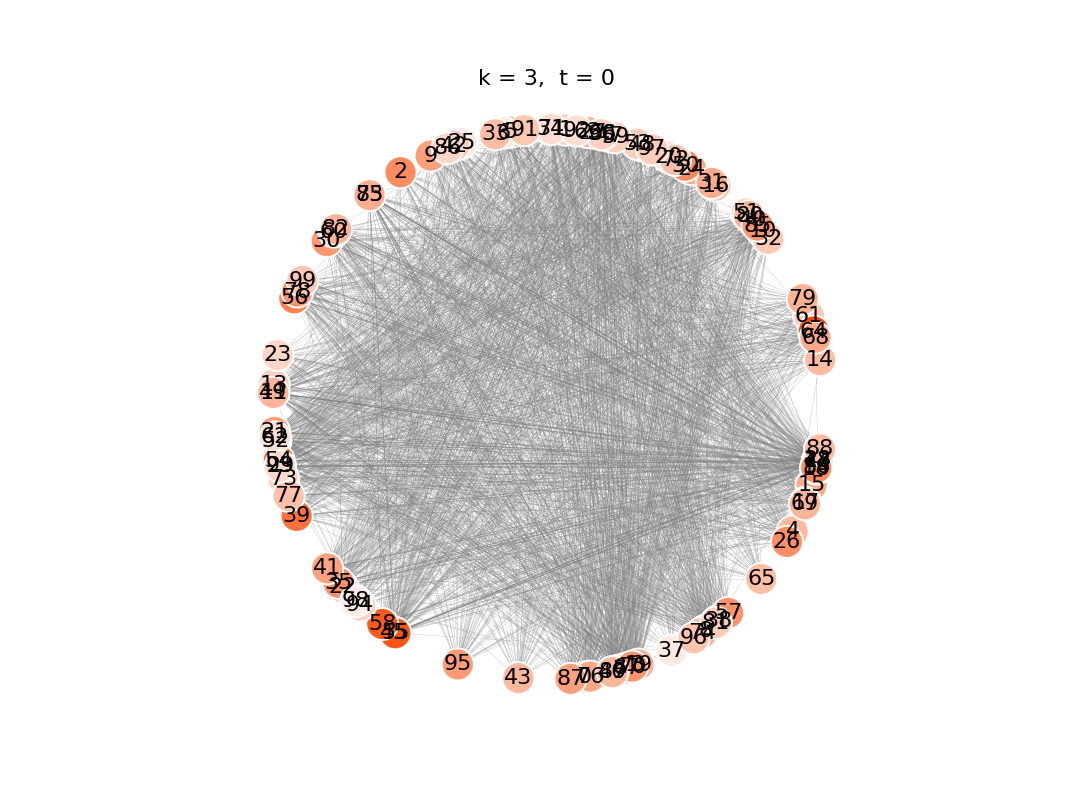

Text(0.5, 1.0, 'k = 3,  t = 0')

In [78]:
t = 0
k = 3

ax = plot_network(Y[k, t], X[t], normalize=True, with_labels=True, 
                  edge_width=0.1)
ax.set_title('k = {},  t = {}'.format(k, t))

# Model Estimation

In [58]:
from multidynet import DynamicMultilayerNetworkLSM
from multidynet.model_selection import train_test_split

# Hold-out 10% of dyads for testing
Y_train, test_indices = train_test_split(Y, test_size=0.1)

model = DynamicMultilayerNetworkLSM(max_iter=500, 
                                    a=4.0, b=20.0, c=10, d=0.1, 
                                    lambda_var_prior=10., 
                                    intercept_var_prior=10.,
                                    lambda_odds_prior=2,
                                    tol=1e-1,
                                    n_init=8,
                                    random_state=123)
model.fit(Y_train)

<IPython.core.display.Javascript object>


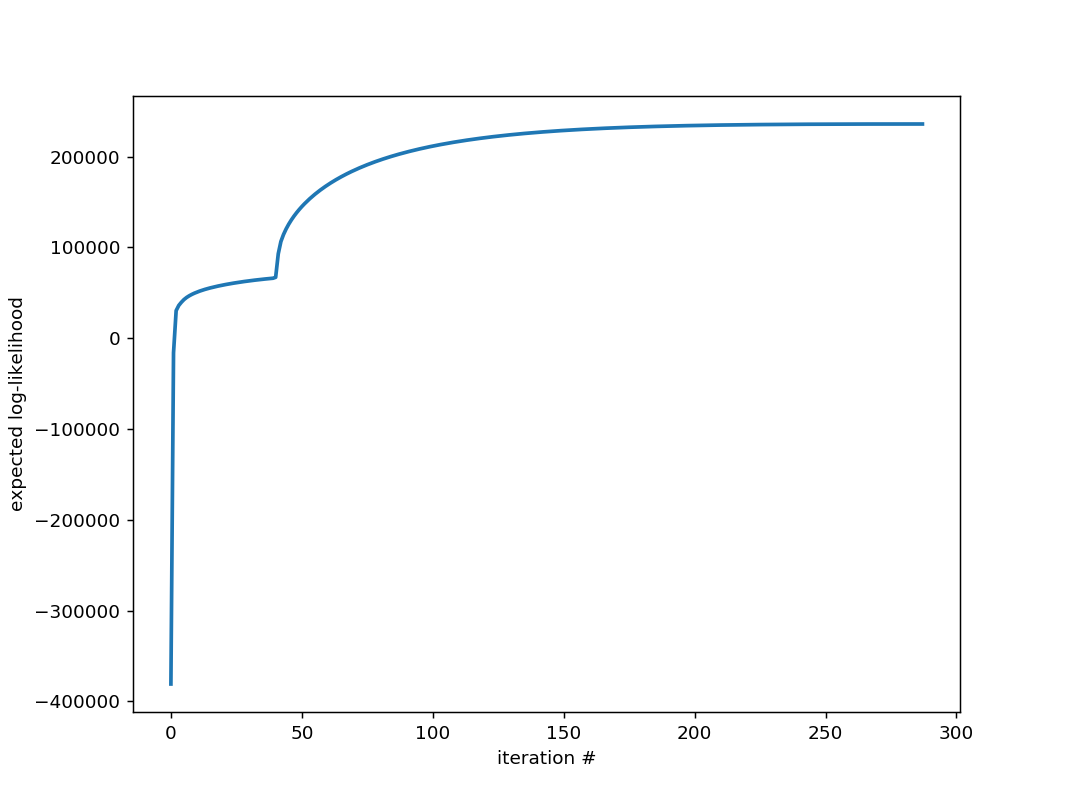

Text(0.5, 0, 'iteration #')

In [60]:
fig, ax= plt.subplots(figsize=(8, 6))
ax.plot(model.logp_, lw=2)
ax.set_ylabel('expected log-likelihood')
ax.set_xlabel('iteration #')

# Parameter Estimates

# $\Lambda_k$

In [59]:
model.lambda_

array([[ 1.        ,  1.        ],
       [ 0.51249774, -0.50820869],
       [-1.83194491,  1.82984983],
       [-1.00120164, -1.00713605]])

# $\beta_k$

In [69]:
model.intercept_

array([-1.01446848, -1.00378947, -0.93461593, -1.0283735 ])

# $\tau^2$

In [70]:
model.tau_sq_

4.586119677223207

# $\sigma^2$

In [71]:
model.sigma_sq_

0.060851727919222554

## Latent Space 

<IPython.core.display.Javascript object>


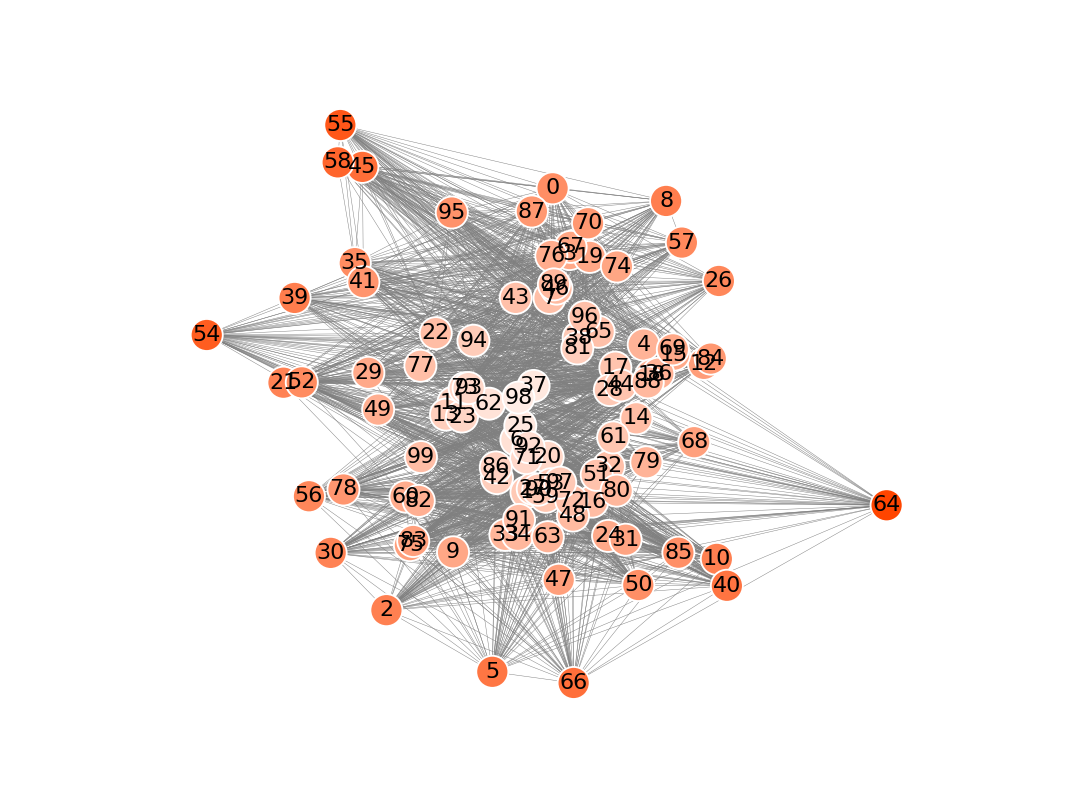

In [96]:
from multidynet.plots import plot_network

t = 0
k = 2
ax = plot_network(Y[k, t],model.X_[t], normalize=False, with_labels=True)

# Performance Diagnostics

## In-sample AUC

In [61]:
model.auc_

0.9646799483170649

## Held-out AUC

In [62]:
from multidynet.metrics import calculate_auc

calculate_auc(Y, model.probas_, test_indices)

0.962888086908839

## Connection Probability Estimates

<IPython.core.display.Javascript object>


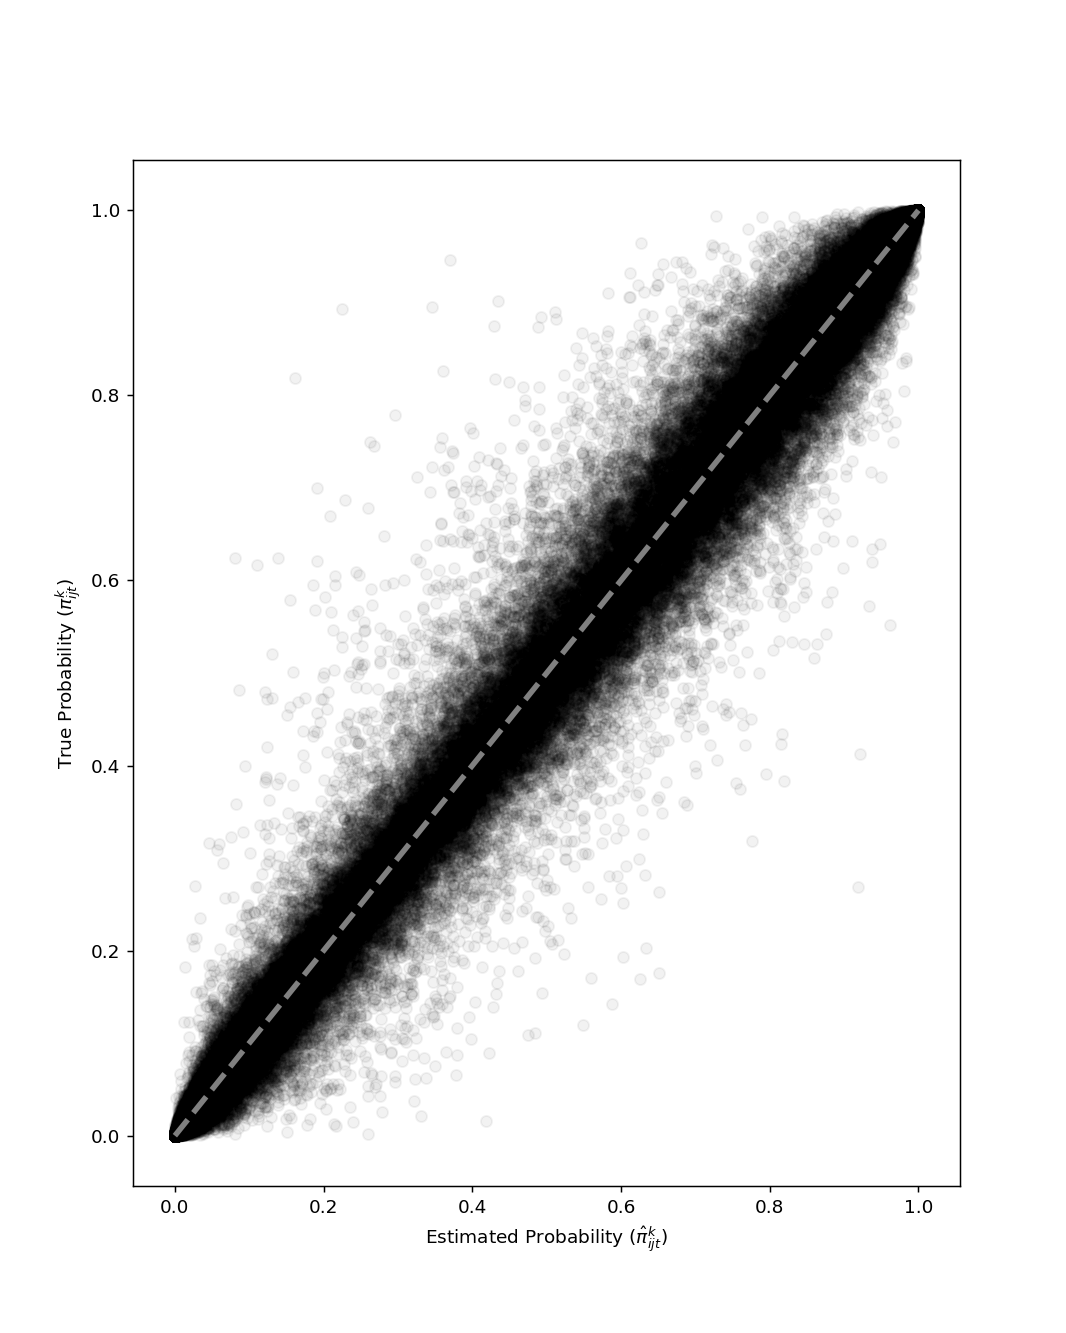

Text(0.5, 0, 'Estimated Probability ($\\hat{\\pi}_{ijt}^k$)')

In [63]:
import seaborn as sns
from scipy.special import expit

fig, ax = plt.subplots(figsize=(8, 10))

n_layers = Y.shape[0]
n_time_steps = X.shape[0]
n_nodes = X.shape[1]
n_dists = int(0.5 * n_nodes * (n_nodes - 1))

p_true = np.zeros((n_layers, n_time_steps, n_dists))
p_est = np.zeros((n_layers, n_time_steps, n_dists))
for k in range(n_layers):
    for t in range(n_time_steps):
        d_est = expit(
            model.intercept_[k] + np.dot(model.X_[t] * model.lambda_[k], model.X_[t].T))
        d_true = expit(intercept[k] + np.dot(X[t] * lmbda[k], X[t].T))

        indices = np.tril_indices_from(d_est, k=-1)
        p_true[k, t] = d_true[indices]
        p_est[k, t] = d_est[indices]

x = np.linspace(*ax.get_xlim())
ax.plot(x, x, '--', color='gray', lw=3)
ax.scatter(p_est.ravel(), p_true.ravel(), alpha=0.05, c='k')
ax.set_ylabel('True Probability ($\pi_{ijt}^k$)')
ax.set_xlabel('Estimated Probability ($\hat{\pi}_{ijt}^k$)')

In [72]:
import pickle

pickle.dump(model, open('model_types_n100_t10.pkl', 'wb'))